#### Resumen del Problema

La fiebre del dengue es una enfermedad transmitida por mosquitos en áreas tropicales y subtropicales. Los síntomas incluyen fiebre, erupción cutánea y dolor muscular en casos leves, pero en casos graves puede causar hemorragias y hasta la muerte. Los factores climáticos, como la temperatura y la precipitación, afectan la transmisión del dengue, y el cambio climático podría aumentar su propagación. La enfermedad solía ser más común en el sudeste asiático y las islas del Pacífico, pero en la actualidad, la mayoría de los casos ocurren en América Latina, con casi 500 millones de casos al año.

Por lo tanto, lo que vamos a hacer a continuación es mediante una información facilitada vamos a intentar predecir la cantidad de casos. Esta información solo la tenemos de dos ciudades del mundo. 

####Importaciones de lo necesario en el proyecto

In [1]:
# Importaciones necesarias
import pandas as pd
import io
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from numpy.core import numeric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

#### Descargamos los 3 ficheros dos de train y un test 

In [2]:
# Importamos los dos ficheros el train y el test
url1 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/dengue_features_test.csv'
dftest = pd.read_csv(url1)
url2 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/dengue_features_train.csv'
dftrain = pd.read_csv(url2)
url3 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/dengue_labels_train.csv'
dftrain_y = pd.read_csv(url3)

In [3]:
#Rellenamos los valores que se encuentran nulos con 0
dftrain.fillna(0, inplace = True)
dftest.fillna(0, inplace = True)

Ver las Columanas que componen el dataframe

In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1456 non-null   float64
 5   ndvi_nw                                1456 non-null   float64
 6   ndvi_se                                1456 non-null   float64
 7   ndvi_sw                                1456 non-null   float64
 8   precipitation_amt_mm                   1456 non-null   float64
 9   reanalysis_air_temp_k                  1456 non-null   float64
 10  reanalysis_avg_temp_k                  1456 non-null   float64
 11  rean

#### Matríz de Correlación

Antes de hacer la Matriz de correlación lo que vamos a hacer es pasar todos los datos categóricos a numéricos, pero como en el anterior apartado hemos eliminado todos los valores que no sean numéricos, no tendríamos problemas.

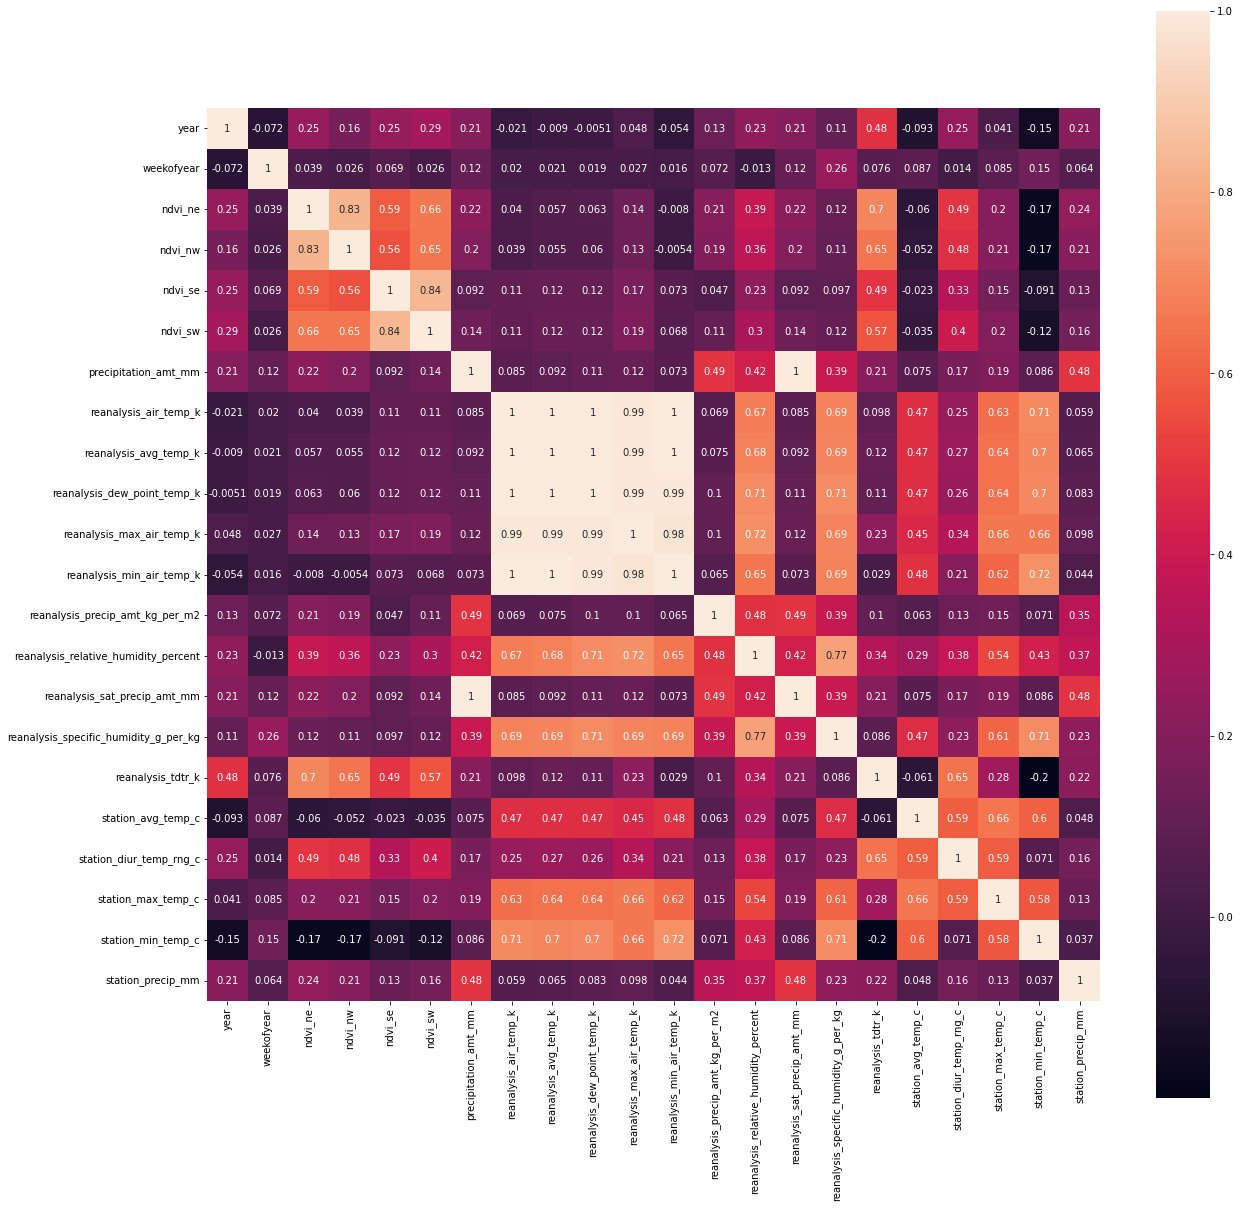

In [5]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(dftrain.corr(), annot=True, square=True)
plt.show()

A continuación, lo que vamos a hacer es quitar o sustituir los valores que yo considere oportunos para poder empezar con el estudio de los datos. Tras varias pruebas con distintas conjuntos de datos y una exaustiva busqueda para conseguir el mejor resultado he llegado a la conclusión de que unicamente omitiendo los valores de 'city', 'week_start_date' y 'year'. Y quitamos también 'reanalysis_sat_precip_amt_mm' debido a que en la matriz anterior muestra una relación de 1 con otro valor.

In [6]:
dftrain.drop(['city'], axis = 1, inplace=True)
dftrain.drop(['week_start_date'], axis = 1, inplace=True)
dftrain.drop(['year'], axis = 1, inplace=True)
dftrain.drop(['reanalysis_sat_precip_amt_mm'], axis = 1, inplace=True)

dftest.drop(['city'], axis = 1, inplace=True)
dftest.drop(['week_start_date'], axis = 1, inplace=True)
dftest.drop(['year'], axis = 1, inplace=True)
dftest.drop(['reanalysis_sat_precip_amt_mm'], axis = 1, inplace=True)

Volvemos a mostrar la matriz de correlación pero con los valores anteriores eliminados. 

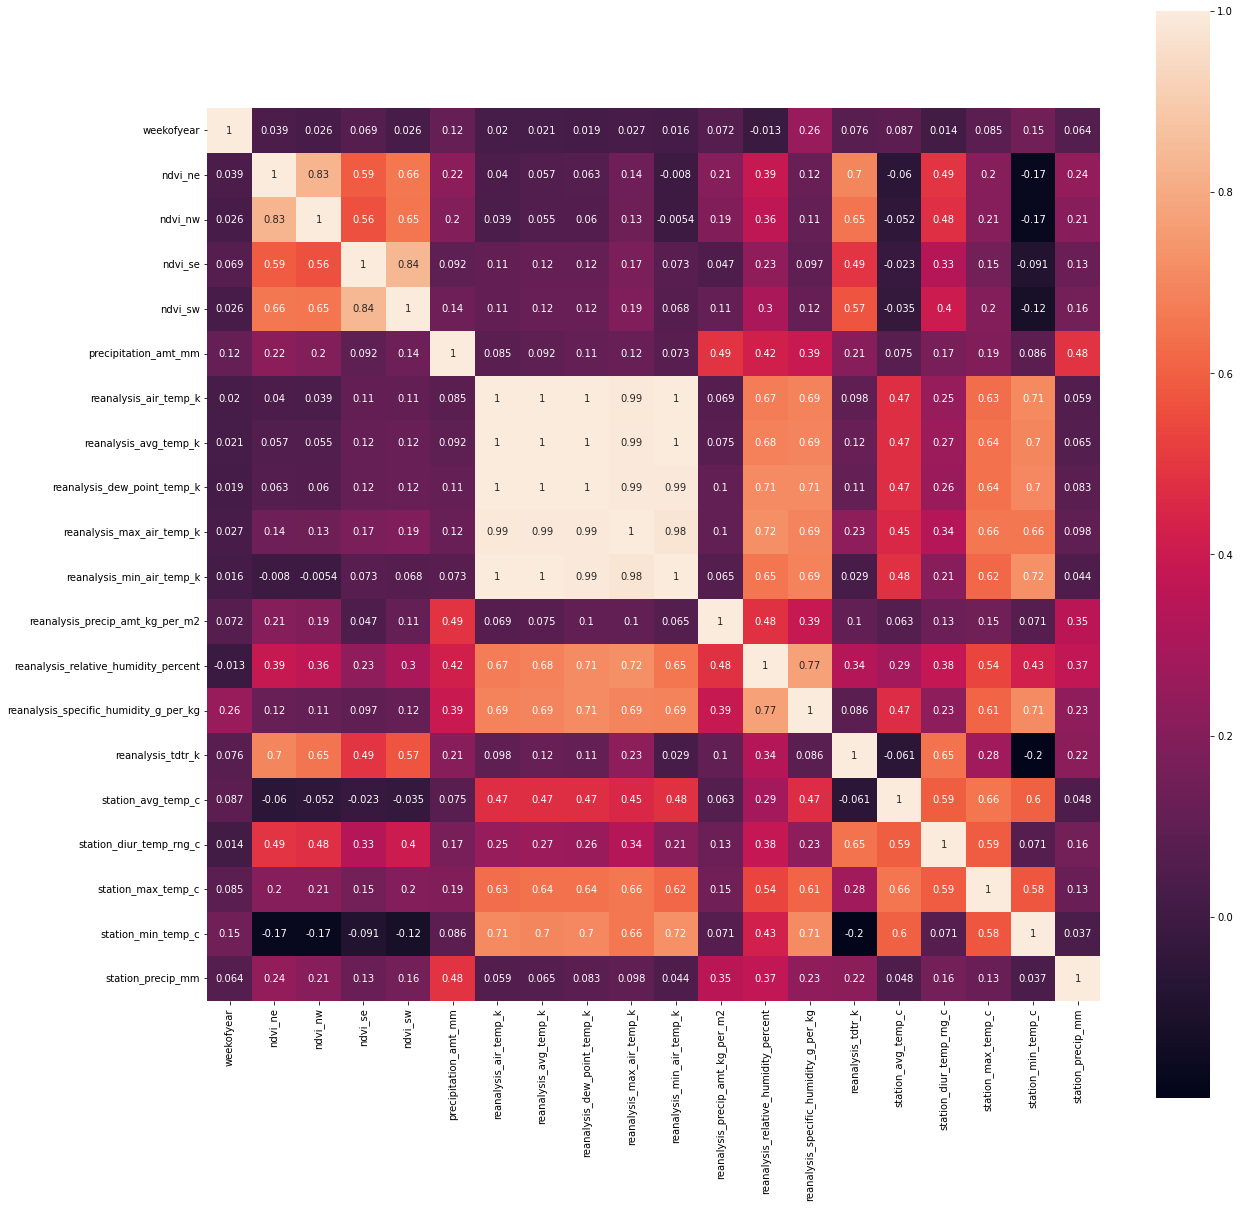

In [7]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(dftrain.corr(), annot=True, square=True)
plt.show()

In [8]:
# Como puedes observar en uno de los intentos paso las ciudades que son valores categóricos a numéricos

# dftrain['city'] = dftrain['city'].replace({'sj': 0, 'iq': 1})
# dftest['city'] = dftest['city'].replace({'sj': 0, 'iq': 1})

#Lo que hacemos es escalar tanto el xtrain y el xtest, pero no las y, ya que, si no la escalamos no haría falta desescalarlo o escalar el predict 
scaler = MaxAbsScaler()
dftrain[dftrain.columns] = scaler.fit_transform(dftrain)
dftest[dftest.columns] = scaler.fit_transform(dftest)

In [9]:
# separamos datos de entrada y salida
# en un ejemplo anterior solo obtenía los datos del data train desde el 2008 hasta el 2010
# dftrain = dftrain.loc[(dftrain['year'] >= 2008)  &  (dftrain['year'] <= 2010)]
X = dftrain
y = dftrain_y['total_cases']

# separamos train y test usando unicamente el dataframe de train descargado anteriormente. 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

In [10]:
regressor = DecisionTreeRegressor() 
regressor

DecisionTreeRegressor()

## GridSearch

La búsqueda en cuadrícula es un enfoque de ajuste de parámetros que permite construir y evaluar metódicamente un modelo para cada combinación de parámetros de algoritmo especificados en una cuadrícula.

In [11]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [16]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

param_dist = { # Number of trees in random forest
              "max_features": ['sqrt', 'log2', None], # Number of features (características) when looking for the best split (división)
              'splitter':['best', 'random'],# The strategy used to choose the split at each node.
              "max_depth": [32,16,8], # Maximum number of levels in tree
              "min_samples_split": [2, 4, 6, 8], #  Minimum number of samples required to split a node
              "min_samples_leaf": [8, 12, 16, 22], # Minimum number of samples required at each leaf(hoja) node
              'criterion': ['squared_error','friedman_mse', 'absolute_error', 'poisson']
            }

In [17]:
# Como saber el número de combinaciones de parámetros que se van a ejecutar
num_combinations = 1
for param in param_dist:
    num_combinations *= len(param_dist[param])
print(f'El número total de combinaciones de parámetros en GridSearchCV es {num_combinations}')

El número total de combinaciones de parámetros en GridSearchCV es 1152


In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

tscv = TimeSeriesSplit(n_splits=5)
#grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv = tscv)
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv = tscv, error_score='raise')

# Fit the random search model
grid_regres.fit(X = x_train, y = y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise', estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [32, 16, 8],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [8, 12, 16, 22],
                         'min_samples_split': [2, 4, 6, 8],
                         'splitter': ['best', 'random']})

In [19]:
# ¿Cómo saber el tipo de scoring que se utiliza?
# Si no se especifica un valor para scoring, por defecto se utiliza la métrica "accuracy" para problemas de clasificación 
# y "r2" para problemas de regresión.

scoring_type = grid_regres.scoring
print(f'El tipo de scoring utilizado en GridSearchCV es {scoring_type}')

El tipo de scoring utilizado en GridSearchCV es None


In [20]:
report(grid_regres.cv_results_, n_top = 3)

Model with rank: 1
Mean validation score: 0.233 (std: 0.241)
Parameters: {'criterion': 'absolute_error', 'max_depth': 32, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 4, 'splitter': 'random'}

Model with rank: 2
Mean validation score: 0.217 (std: 0.132)
Parameters: {'criterion': 'absolute_error', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 12, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 3
Mean validation score: 0.199 (std: 0.136)
Parameters: {'criterion': 'poisson', 'max_depth': 16, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 8, 'splitter': 'random'}



In [21]:
grid_regres.best_estimator_

DecisionTreeRegressor(criterion='absolute_error', max_depth=32,
                      min_samples_leaf=8, min_samples_split=4,
                      splitter='random')

In [22]:
# choose the best
best_grid = grid_regres.best_estimator_

# fit and predict
best_grid.fit( X = x_train, y = y_train)
y_pred = best_grid.predict(X = x_test)

# EVALUATE 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print ('MAE', mae)


MAE 19.439359267734552


/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


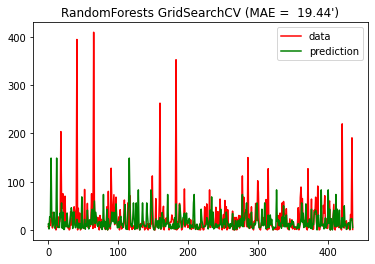

In [23]:
from sklearn.metrics import mean_absolute_error
                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests GridSearchCV (MAE = %6.2f')" % ( mae))

plt.show()

In [24]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('weekofyear','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','precipitation_amt_mm','reanalysis_air_temp_k','reanalysis_avg_temp_k',
                             'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k','reanalysis_precip_amt_kg_per_m2',  'reanalysis_relative_humidity_percent',
                             'reanalysis_specific_humidity_g_per_kg','reanalysis_tdtr_k','station_avg_temp_c','station_diur_temp_rng_c' ,'station_max_temp_c','station_min_temp_c','station_precip_mm') ,
              'Decision Tree': best_grid.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,weekofyear,0.341887
1,ndvi_ne,0.018678
2,ndvi_nw,0.005522
3,ndvi_se,0.081046
4,ndvi_sw,0.010557
5,precipitation_amt_mm,0.002274
6,reanalysis_air_temp_k,0.018028
7,reanalysis_avg_temp_k,0.000650
8,reanalysis_dew_point_temp_k,0.033133
9,reanalysis_max_air_temp_k,0.032483


### Descargar el modelo predicho

Lo que estoy haciendo a continuación es predecir con el dftest que son los de xtest y luego pasamos de float a int. Para finalizar descargamos el csv donde tenemos que poner los valores recogidos y descargamos.

In [25]:
y_pred = best_grid.predict(dftest)
y_pred = y_pred.astype(int)

In [26]:
url4 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/submission_format.csv'
dfsubmission = pd.read_csv(url4)
dfsubmission['total_cases'] = y_pred

In [27]:
dfsubmission.to_csv('resultado-v2_GridSearchCV.csv', index=False)

## RandomizedSearch

Para utilizar RandomizedSearchCV, primero necesitamos crear el conjunto de parámetros a muestrear durante el proceso de optimización.



In [29]:
params_dist = {
              "n_estimators": [32, 64, 128], # Number of trees in random forest
              "max_features": ['sqrt', 'log2', None], # Number of features (características) when looking for the best split (división)
              "max_depth": [32,16,8], # Maximum number of levels in tree
              "min_samples_split": [2, 4, 6, 8], #  Minimum number of samples required to split a node
              "min_samples_leaf": [8, 12, 16, 22], # Minimum number of samples required at each leaf(hoja) node
              # Al utilizar timeSeriesSplit en GridSearchCV tuve que quitar el parámetro True para que no diese error
              # El utilizar TimeSeriesSplit en GridSearchCV implica un ajuste en los hiperparámetros para las pruebas con series temporales
              # ya que pueden provocar error
              # Importante: la validación cruzada en series de tiempo, como TimeSeriesSplit, es una forma adecuada de evaluar el rendimiento 
              # de los modelos de aprendizaje automático en datos temporales. Sin embargo, es importante tener en cuenta que, 
              # en algunos casos, puede producir puntajes de validación cruzada más bajos que otros métodos de validación cruzada debido 
              # a la rigurosidad de la división de los datos en conjuntos de entrenamiento y validación.
              #
              #"bootstrap": [False] # Method of selecting for training each tree, If False, the whole dataset is used to build each tree.
                            # Use False when the dataset use Temporal id
              "bootstrap": [True, False] # Method of selecting for training each tree, If False, the whole dataset is used to build each tree.
            }

En cada iteración, el algoritmo elegirá una combinación diferente de las características. Si se probaran de forma exhaustiva todas las características el problema se volvería muy costoso computacionalmente. Al menos al utilizar búsqueda aleatoria se seleccionará al azar una muestra de las mismas para buscar en un reducido pero significativo rango de valores.


Los argumentos más importantes en RandomizedSearchCV son *n_iter*, que controla el número de combinaciones diferentes a probar, y *cv*, que es el número de *cruces* a usar para la validación cruzada. Más iteraciones cubrirán un espacio de búsqueda más amplio y más *cruces* de cv reducen las posibilidades de sobreaprendizaje, pero al aumentar cada una de ellas se incrementará el tiempo de ejecución. 

Vamos a ejecutarla utilizando la validación cruzada (5-fold) y posteriormente busca entre 100 combinaciones diferentes de entre las especificadas

In [30]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
rand = RandomForestRegressor()

# MUY INTERESANTE: Probar a realizar el entrenamienmto utilizando timeSeriesSplit y comentar las diferencias en lsoresultados obtenidos
tscv = TimeSeriesSplit()
#rnd_regres = RandomizedSearchCV(estimator = rand, param_distributions = param_dist, n_iter = 100, cv = tscv, random_state=0, n_jobs = -1)
rnd_regres = RandomizedSearchCV(rand, params_dist, n_iter = 100, cv = tscv, error_score='raise')

#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

# Fit the random search model
rnd_regres.fit(X = x_train, y = y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [32, 16, 8],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [8, 12, 16, 22],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [32, 64, 128]})

In [31]:
report(rnd_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.276 (std: 0.158)
Parameters: {'n_estimators': 32, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 32, 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.272 (std: 0.145)
Parameters: {'n_estimators': 128, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 16, 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.270 (std: 0.155)
Parameters: {'n_estimators': 64, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 16, 'bootstrap': False}

Model with rank: 4
Mean validation score: 0.269 (std: 0.148)
Parameters: {'n_estimators': 128, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 16, 'bootstrap': False}

Model with rank: 5
Mean validation score: 0.268 (std: 0.161)
Parameters: {'n_estimators': 64, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 32, 'boo

In [32]:
rnd_regres.best_params_

{'n_estimators': 32,
 'min_samples_split': 6,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 32,
 'bootstrap': False}

Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente 

In [33]:
# choose the best

best_random = rnd_regres.best_estimator_
# fit and predict
best_random.fit( X = x_train, y = y_train)
y_pred = best_random.predict(X = x_test)

# EVALUATE 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print ('MAE', mae)



MAE 16.419573672775545


Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


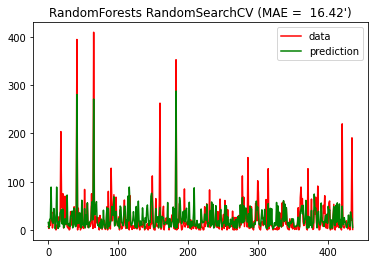

In [34]:
from sklearn.metrics import mean_absolute_error
                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests RandomSearchCV (MAE = %6.2f')" % ( mae))

plt.show()

In [35]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('weekofyear','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','precipitation_amt_mm','reanalysis_air_temp_k','reanalysis_avg_temp_k',
                             'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k','reanalysis_precip_amt_kg_per_m2',  'reanalysis_relative_humidity_percent',
                             'reanalysis_specific_humidity_g_per_kg','reanalysis_tdtr_k','station_avg_temp_c','station_diur_temp_rng_c' ,'station_max_temp_c','station_min_temp_c','station_precip_mm') ,
              'Decision Tree': best_grid.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,weekofyear,0.341887
1,ndvi_ne,0.018678
2,ndvi_nw,0.005522
3,ndvi_se,0.081046
4,ndvi_sw,0.010557
5,precipitation_amt_mm,0.002274
6,reanalysis_air_temp_k,0.018028
7,reanalysis_avg_temp_k,0.000650
8,reanalysis_dew_point_temp_k,0.033133
9,reanalysis_max_air_temp_k,0.032483


### Descargar el modelo predicho

Lo que estoy haciendo a continuación es predecir con el dftest que son los de xtest y luego pasamos de float a int. Para finalizar descargamos el csv donde tenemos que poner los valores recogidos y descargamos.

In [36]:
y_pred = best_random.predict(dftest)
y_pred = y_pred.astype(int)

In [37]:
url4 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/submission_format.csv'
dfsubmission = pd.read_csv(url4)
dfsubmission['total_cases'] = y_pred

In [38]:
dfsubmission.to_csv('resultado-v2_RandomForestRegressor.csv', index=False)

## Modelo Regresión Polinómica




In [39]:
# Importamos la clase de Regresión Lineal de scikit-learn
from sklearn.linear_model import LinearRegression 
# para generar características polinómicas
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures 

In [40]:
X = dftrain
y = dftrain_y['total_cases']

# separamos train y test usando unicamente el dataframe de train descargado anteriormente. 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

In [41]:
# Definimos una lista de posibles grados del polinomio
degrees = [1, 2, 3, 4, 5]

In [55]:
dicc_results = {}

# Realizamos la validación cruzada para cada grado del polinomio
for degree in degrees:

  # Creamos una matriz de características polinómicas
  poly = PolynomialFeatures(degree=degree)
  X_poly_train = poly.fit_transform(x_train.to_numpy())
  X_poly_test = poly.transform(x_test.to_numpy())

  # Entrenamos un modelo de regresión lineal con las características polinómicas
  lin_reg = LinearRegression()
  lin_reg.fit(X_poly_train, y_train)

  # Predecimos los valores de y para los datos de entrenamiento y prueba
  y_test_pred = lin_reg.predict(X_poly_test)

  # Calculamos el error cuadrático medio para los datos de entrenamiento y prueba
  mae_test = mean_absolute_error(y_test, y_test_pred)
  dicc_results[degree] = mae_test

  print('Grado del polinomio:', degree)
  print('MAE para datos de prueba:', mae_test)
  print('-------------------------------------')

Grado del polinomio: 1
MAE para datos de prueba: 21.865140573229866
-------------------------------------
Grado del polinomio: 2
MAE para datos de prueba: 33.09487820079209
-------------------------------------
Grado del polinomio: 3
MAE para datos de prueba: 56219.06394002156
-------------------------------------
Grado del polinomio: 4
MAE para datos de prueba: 32918.9596370589
-------------------------------------
Grado del polinomio: 5
MAE para datos de prueba: 2315.5276707572652
-------------------------------------


In [56]:
poly = PolynomialFeatures(degree = min(dicc_results), include_bias=True)

X_poly_train = poly.fit_transform(x_train.to_numpy())
X_poly_test = poly.transform(x_test.to_numpy())
test = poly.transform(dftest.to_numpy())

# Entrenamos un modelo de regresión lineal con las características polinómicas
lin_reg = LinearRegression()
lin_reg.fit(X_poly_train, y_train)

# Predecimos los valores de y para los datos de entrenamiento y prueba
y_test_pred = lin_reg.predict(test)
y_pred = y_test_pred.astype(int)

#El coeficiente de determinación r2_score es una medida estadística que 
#indica qué tan bien se ajusta un modelo de regresión lineal a los datos observados. 
#Es un número entre 0 y 1, donde 0 indica que el modelo no explica ninguna variación 
#en los datos y 1 indica que el modelo explica perfectamente la variación en los datos.

print(r2_score(y_test_pred, y_pred))



0.999369767215527


### Descargar el modelo predicho

Lo que estoy haciendo a continuación es predecir con el dftest que son los de xtest y luego pasamos de float a int. Para finalizar descargamos el csv donde tenemos que poner los valores recogidos y descargamos.

In [57]:
url4 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/submission_format.csv'
dfsubmission = pd.read_csv(url4)
dfsubmission['total_cases'] = y_pred

In [58]:
dfsubmission.to_csv('resultado-v2_RegressionPolinomial.csv', index=False)